In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from time import time
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import splitfolders
import shutil
import time



### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Sexta tarea corta


Profesora: María Auxiliadora Mora

Estudiantes:
 1. Pablo Alberto Muñoz Hidalgo
 2. Luis Andrés Rojas Murillo

Medio de entrega: Por medio del TEC-Digital.

Entregables: Un archivo en Jupyter ( .IPYNB ). 

Modo de trabajo: En parejas.

---

Objetivo: En el presente trabajo se tiene como objetivo el desarrollo y entrenaiento de una red convolucional con la capacidad de distinguir imagenes a partir de la implementación de los algoritmos especificos para esta labor.

Problema: Dada una colección de imagenes de animales se debe de desarrollar una red convolucional capaz de clasificar la imagenes, y con los resultados de la aplicacion de esta herreminata se debe de aplicar una revision a los resultados y sobre esto dse debe de desarrollar un sistema estadístico para el analisis del rendimiento y analisis de posbles mejoras u optimizaciones para este proceso.  



### Sección de carga, normalización y exploración los datos.

In [10]:
#reduce the images quality to 3x32x32
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#reduce the images quality to 3x32x32
transform_hd = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [11]:
# Define la ruta a la carpeta que contiene las imágenes
ruta_imagenes = "animals"
#borra la carpeta llamada 'cnn' si existe
shutil.rmtree('cnn', ignore_errors=True)
splitfolders.ratio('animals', output="cnn", seed=1337, ratio=(.75, 0.125,0.125)) 
ruta_imagenes = "cnn"

Copying files: 5400 files [00:05, 1029.09 files/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Número de imágenes de entrenamiento:  4050
Número de imágenes de prueba:  720



IMAGEN A RESOLUCION 48x48


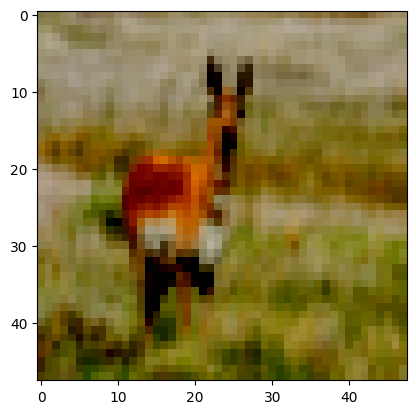

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).





IMAGEN A RESOLUCION 128x128


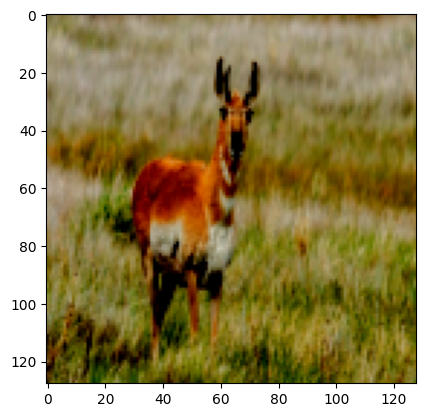

In [12]:


# Carga de los datos de la ruta imagenes, crea un set de training con la carpeta train, luego uno de testing con la carpeta test
# y por último uno de validación con la carpeta val
testset = datasets.ImageFolder(ruta_imagenes + "/test", transform=transform)
trainset = datasets.ImageFolder(ruta_imagenes + "/train", transform=transform)


testset_hd = datasets.ImageFolder(ruta_imagenes + "/test", transform=transform_hd)
trainset_hd = datasets.ImageFolder(ruta_imagenes + "/train", transform=transform_hd)


# Se definen objetos para la carga de los datos en mini batches (DataLoader),
# que combinan y barajan el conjunto de datos. 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Se definen objetos para la carga de los datos en mini batches (DataLoader),
# que combinan y barajan el conjunto de datos. 

trainloader_hd = torch.utils.data.DataLoader(trainset_hd, batch_size=32, shuffle=True)
testloader_hd = torch.utils.data.DataLoader(testset_hd, batch_size=32, shuffle=False)

#Normaliza los datos para ser procesados

# Imprime el número de imágenes y clases en el conjunto de datos
print("Número de imágenes de entrenamiento: ", len(trainset))
print("Número de imágenes de prueba: ", len(testset))

#imprime lcualquier imagen del set de prueba
print('\n\n\nIMAGEN A RESOLUCION 48x48')
plt.imshow(trainset[0][0].permute(1, 2, 0))
plt.show()
print('\n\n\nIMAGEN A RESOLUCION 128x128')
plt.imshow(trainset_hd[0][0].permute(1, 2, 0))
plt.show()


### Analisis de las imagenes 
Se concluye que el conjunto de imagenes para la prueba es una coleccion de imagenes representativas de especies animales clasificadas según su especie en directorios especificos los cuales se utilizarán para una clasificcaion automática a travéz del perceptrón.

### Estadísticas

In [13]:
# Genera estadísticas del conjunto de datos
etiquetas = [etiqueta for _, etiqueta in testset]
etiquetas_dict = {clase: etiquetas.count(indice_clase) for indice_clase, clase in enumerate(testset.classes)}

# Estadísticas 1: Cantidad de registros por clase
# Se almacena en un diccionario la clase con su respectiva incidencia en el conjunto de datos
incidencias = {clase: etiquetas.count(indice_clase) for indice_clase, clase in enumerate(testset.classes)}



##### Distribución de imagenes por cada clase 

         Clase  Incidencia
0     antelope           8
1       badger           8
2          bat           8
3         bear           8
4          bee           8
..         ...         ...
85       whale           8
86        wolf           8
87      wombat           8
88  woodpecker           8
89       zebra           8

[90 rows x 2 columns]


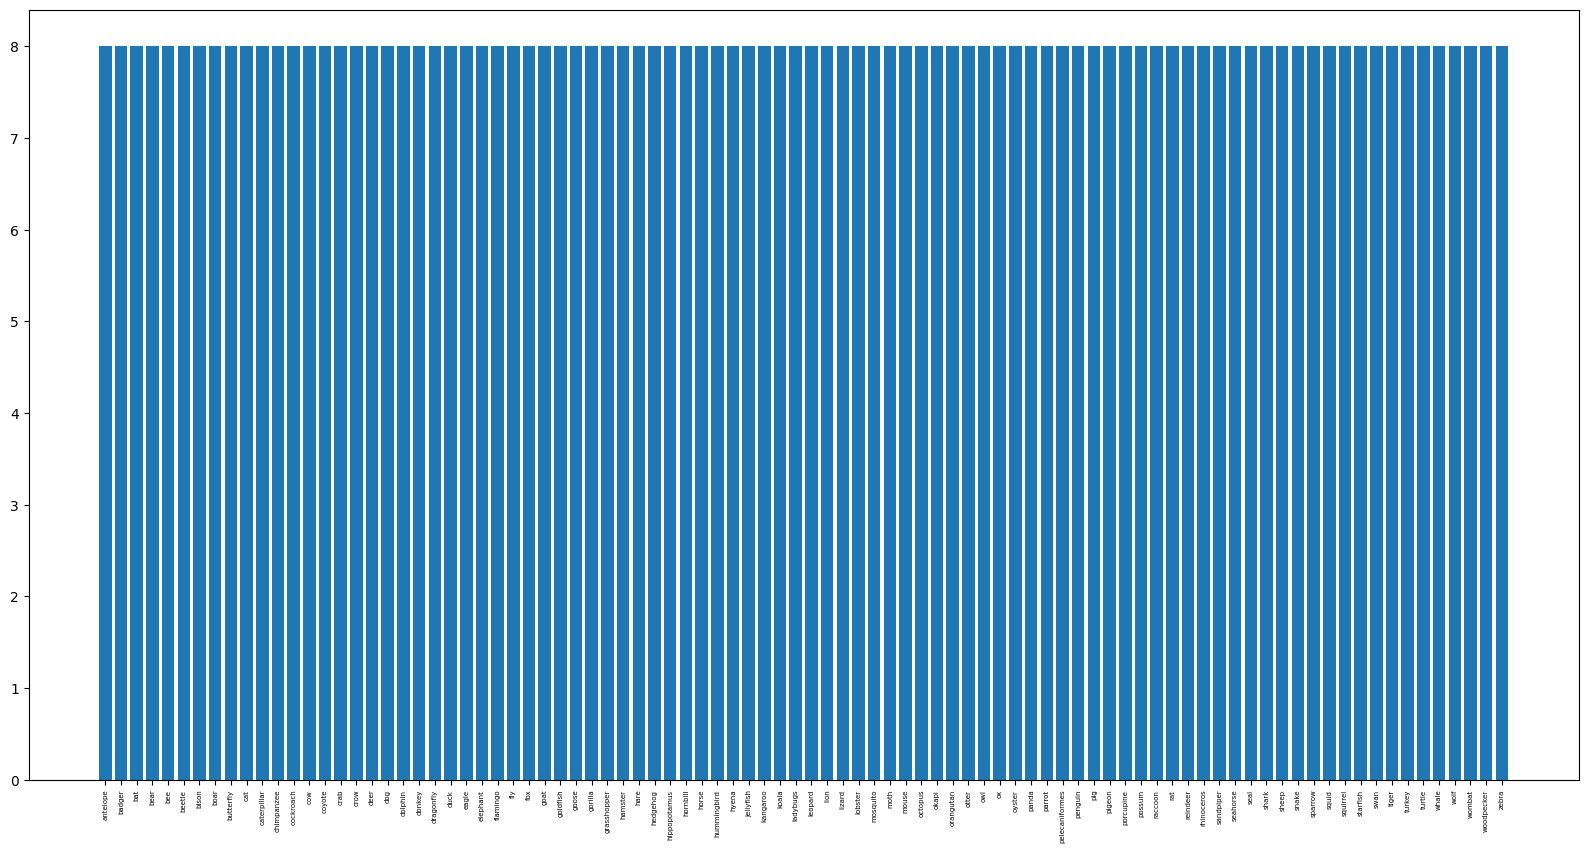

In [14]:
# se grafican las incidencias con los nombres de las claces en forma vertical y con una funete muy pequeña
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, fontsize=5)

plt.bar(incidencias.keys(), incidencias.values())

#haga una tabla con las incidencias de cada clase usando pandas
df = pd.DataFrame(incidencias.items(), columns=['Clase', 'Incidencia'])
print(df)

    


### Definición de la red convolucional.

In [15]:
print('\n\n\nTamaño y datos generales del trainloader 48x48')
print(trainloader.dataset[-1][0].shape)
print('\n\n\nTamaño y datos generales del trainloader 128x128')
print(trainloader_hd.dataset[-1][0].shape)





Tamaño y datos generales del trainloader 48x48
torch.Size([3, 48, 48])



Tamaño y datos generales del trainloader 128x128
torch.Size([3, 128, 128])


In [16]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flat = nn.Flatten()
        
        self.fc3 = nn.Linear(32 * 24 * 24, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        
        #Cantidad de clases 90
        self.fc4 = nn.Linear(512, 90)
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

model = CNN()
print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Iteraciones
epochs = 25
results = []
#Print the time it takes to run it
start_time = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            acc += (torch.argmax(outputs, 1) == labels).float().sum()
            count += len(labels)
        acc /= count
    results.append([(epoch+1),loss.detach().numpy(), ((acc/count).detach().numpy()*100)])
    print("Epoch: {}/{}.. ".format(epoch+1, epochs), 
            "Training Loss: {:.3f}.. ".format(loss.detach().numpy()),
            "Test Accuracy: {:.3f}%".format((acc/count).detach().numpy()*10000))

print("\n--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'cifar10_model.pth')


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=18432, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=90, bias=True)
)
Epoch: 1/25..  Training Loss: 4.469..  Test Accuracy: 0.463%
Epoch: 2/25..  Training Loss: 4.362..  Test Accuracy: 0.405%
Epoch: 3/25..  Training Loss: 4.345..  Test Accuracy: 0.540%
Epoch: 4/25..  Training Loss: 4.473..  Test Accuracy: 0.617%
Epoch: 5/25..  Training Loss: 4.004..  Test Accuracy: 1.042%
Epoch: 6/25..  Training Loss: 3.720..  Test Accuracy: 1.042%
Epoch: 7/25..  Training Loss: 3.929..  Test Accuracy: 0.887%
Epoch: 8/25..  T

In [17]:


class CNN_HD(nn.Module):
    def __init__(self):
        super(CNN_HD, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flat = nn.Flatten()
        
        self.fc3 = nn.Linear(32 * 24 * 24, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        
        #Cantidad de clases 90
        self.fc4 = nn.Linear(512, 90)
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

model = CNN_HD()
print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
start_time = time.time()
#Iteraciones
epochs = 25
results_hd = []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            acc += (torch.argmax(outputs, 1) == labels).float().sum()
            count += len(labels)
        acc /= count
    results_hd.append([(epoch+1),loss.detach().numpy(), ((acc/count).detach().numpy()*100)])
    print("Epoch: {}/{}.. ".format(epoch+1, epochs), 
            "Training Loss: {:.3f}.. ".format(loss.detach().numpy()),
            "Test Accuracy: {:.3f}%".format((acc/count).detach().numpy()*10000))
    
print("\n--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'cifar10_model_hd.pth')


CNN_HD(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=18432, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=90, bias=True)
)
Epoch: 1/25..  Training Loss: 4.486..  Test Accuracy: 0.289%
Epoch: 2/25..  Training Loss: 4.448..  Test Accuracy: 0.386%
Epoch: 3/25..  Training Loss: 4.584..  Test Accuracy: 0.579%
Epoch: 4/25..  Training Loss: 3.884..  Test Accuracy: 0.829%
Epoch: 5/25..  Training Loss: 4.376..  Test Accuracy: 0.733%
Epoch: 6/25..  Training Loss: 3.907..  Test Accuracy: 1.254%
Epoch: 7/25..  Training Loss: 4.450..  Test Accuracy: 0.829%
Epoch: 8/25..

Muestra de los resultados obtenidos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

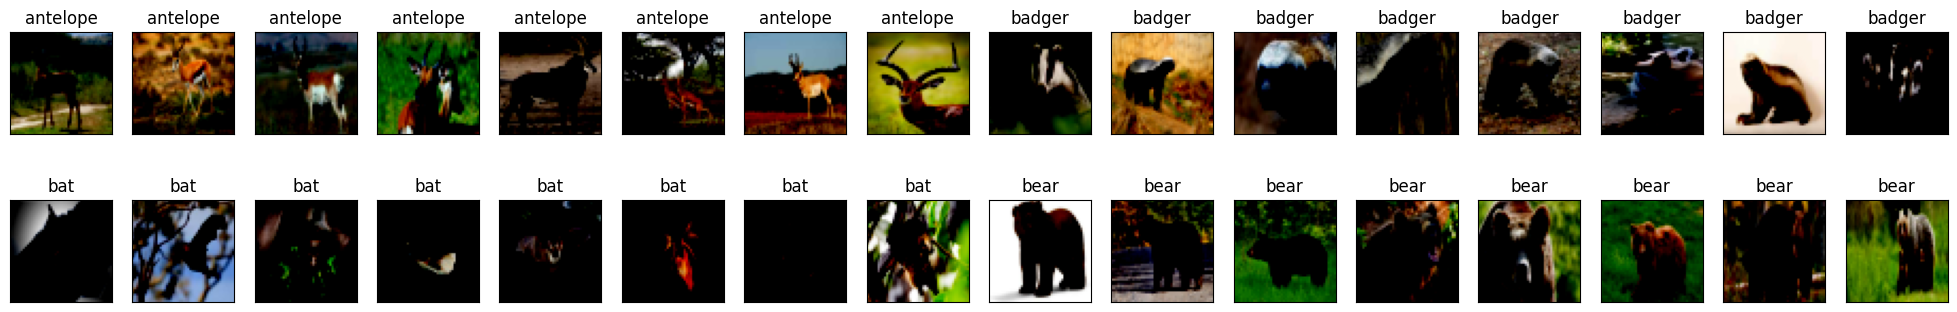

In [18]:
#Clases asociadas a las imágenes.
classes_hd = testloader.dataset.classes

dataiter = iter(testloader)
images, labels = next(dataiter)


#plt.figure(figsize=(20, 10))
#plt.axis("off")
#plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=15, padding=1, normalize=True), (1, 2, 0)))
#plt.show()
# Se muestran las imágenes de prueba, muestra 100 imagenes y sus predicciones de manera ordenada en una tabla
# Se muestran las imágenes de prueba, muestra 100 imagenes y sus predicciones de manera ordenada en una tabla
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes_hd[labels[idx]])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

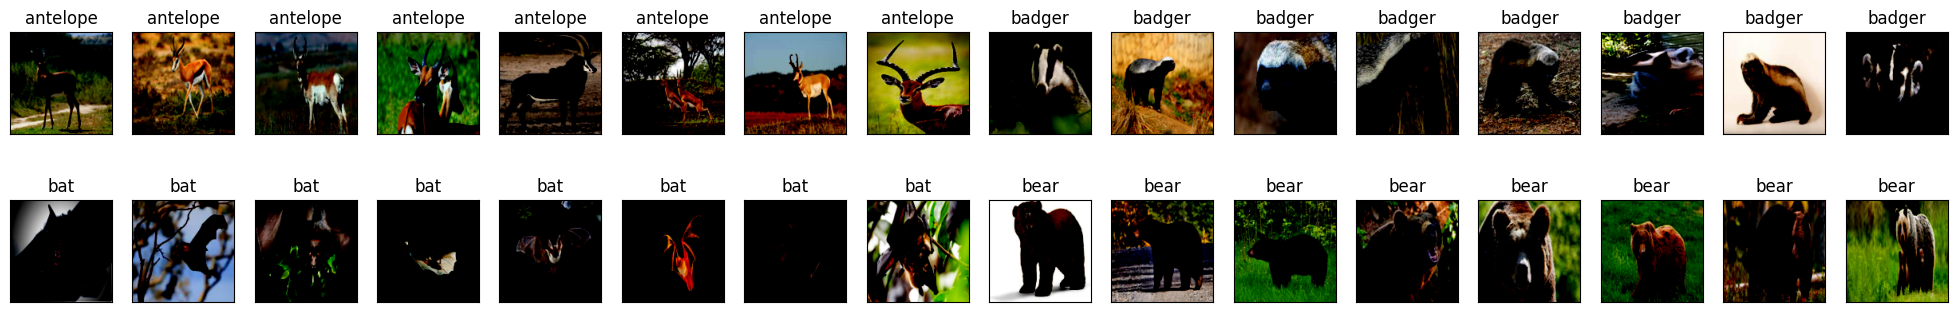

In [19]:
#Clases asociadas a las imágenes.
classes_hd = testloader_hd.dataset.classes

dataiter = iter(testloader_hd)
images, labels = next(dataiter)


#plt.figure(figsize=(20, 10))
#plt.axis("off")
#plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=15, padding=1, normalize=True), (1, 2, 0)))
#plt.show()
# Se muestran las imágenes de prueba, muestra 100 imagenes y sus predicciones de manera ordenada en una tabla
# Se muestran las imágenes de prueba, muestra 100 imagenes y sus predicciones de manera ordenada en una tabla
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes_hd[labels[idx]])
plt.show()

## Analisis de resultados

Resultados con imagenes de 48x48

    Época  % Perdida  % Exactitud
0       1    4.46924     0.462963
1       2  4.3619995     0.405093
2       3   4.344959     0.540123
3       4   4.472854     0.617284
4       5  4.0035686     1.041667
5       6   3.720053     1.041667
6       7   3.928658     0.887346
7       8  3.7863553     1.080247
8       9  3.7629504     1.234568
9      10  3.3118355     1.157407
10     11  3.2845018     1.369599
11     12  3.7823563     1.388889
12     13  3.5202427     1.369599
13     14  3.3528345     1.581790
14     15  3.1903808     1.639660
15     16  2.4881656     1.620370
16     17  3.0876875     1.697531
17     18  3.0099473     1.851852
18     19  2.4085093     1.948302
19     20  2.7165098     1.716821
20     21   2.545929     2.102623
21     22  3.0521472     2.334105
22     23  2.1504366     2.083333
23     24   2.121234     2.527006
24     25  1.1969395     2.372685


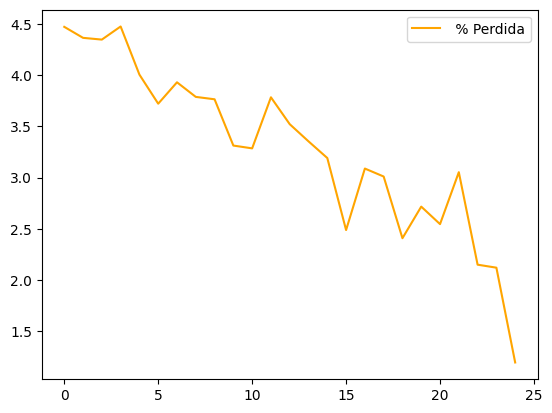

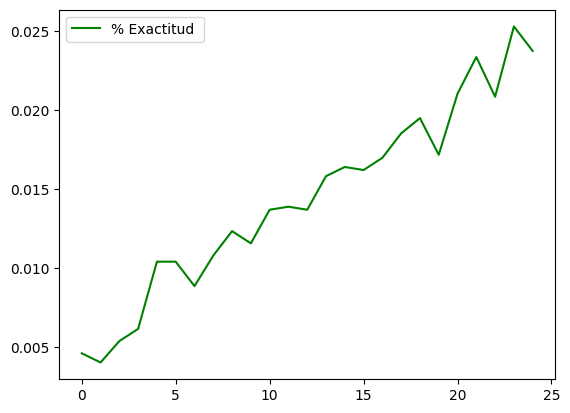

In [20]:

#se hace una tabla con las columnas marcadas con los tensores de loss y accuracy
df = pd.DataFrame(results, columns=['Época', '% Perdida', '% Exactitud'])
#multiplica la exactitud por 1000
df['% Exactitud'] = df['% Exactitud'] * 100
print(df)


#se grafican los tensores de loss y accuracy por separado
results = np.array(results)
plt.plot(results[:, 1], label=' % Perdida', color='orange')
plt.legend()
plt.show()

results = np.array(results)
plt.plot(results[:, 2], label='% Exactitud ', color= 'green')
plt.legend()
plt.show()


Resultados con imagenes de 128x128

    Época  % Perdida  % Exactitud
0       1  4.4863157     0.289352
1       2  4.4476438     0.385802
2       3   4.584389     0.578704
3       4   3.884284     0.829475
4       5  4.3757324     0.733025
5       6  3.9065213     1.253858
6       7   4.449759     0.829475
7       8  4.1146827     1.369599
8       9  3.8585112     1.350309
9      10  3.3072457     1.118827
10     11  3.5272985     1.253858
11     12    3.54648     1.388889
12     13  3.3414533     1.543210
13     14   3.492434     1.581790
14     15  3.0656106     1.832562
15     16  2.8226705     1.890432
16     17  2.7094717     2.006173
17     18   2.549996     1.986883
18     19  2.8838072     2.160494
19     20  2.1120462     2.160494
20     21  2.5721567     2.160494
21     22  1.9005599     2.353395
22     23   2.645008     2.391975
23     24  2.2922654     2.295525
24     25  2.1554973     2.488426


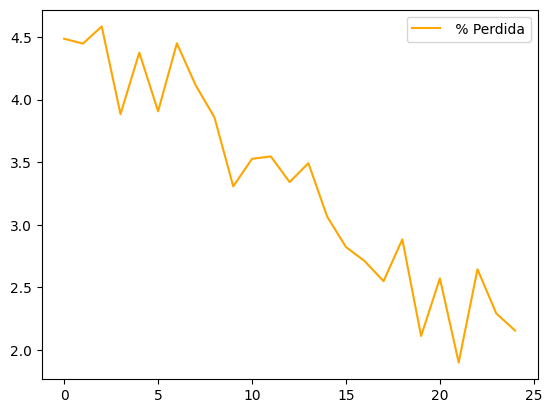

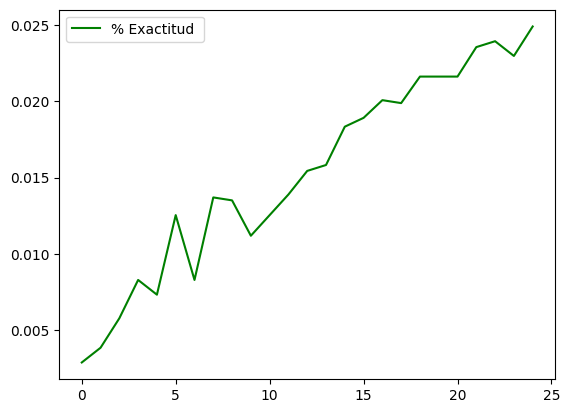

In [21]:


#se hace una tabla con las columnas marcadas con los tensores de loss y accuracy
df = pd.DataFrame(results_hd, columns=['Época', '% Perdida', '% Exactitud'])
#multiplica la exactitud por 1000
df['% Exactitud'] = df['% Exactitud'] * 100
print(df)


#se grafican los tensores de loss y accuracy por separado
results_hd = np.array(results_hd)
plt.plot(results_hd[:, 1], label=' % Perdida', color='orange')
plt.legend()
plt.show()

results_hd = np.array(results_hd)
plt.plot(results_hd[:, 2], label='% Exactitud ', color= 'green')
plt.legend()
plt.show()


#### Analisis de la comparativa entre las dos corridas de ejemplo con diferentes resoluciones de imagenes

    Época  % Perdida  % Exactitud  % Perdida HD  % Exactitud HD
0     1.0   4.469240     0.462963      4.486316        0.289352
1     2.0   4.362000     0.405093      4.447644        0.385802
2     3.0   4.344959     0.540123      4.584389        0.578704
3     4.0   4.472854     0.617284      3.884284        0.829475
4     5.0   4.003569     1.041667      4.375732        0.733025
5     6.0   3.720053     1.041667      3.906521        1.253858
6     7.0   3.928658     0.887346      4.449759        0.829475
7     8.0   3.786355     1.080247      4.114683        1.369599
8     9.0   3.762950     1.234568      3.858511        1.350309
9    10.0   3.311836     1.157407      3.307246        1.118827
10   11.0   3.284502     1.369599      3.527298        1.253858
11   12.0   3.782356     1.388889      3.546480        1.388889
12   13.0   3.520243     1.369599      3.341453        1.543210
13   14.0   3.352834     1.581790      3.492434        1.581790
14   15.0   3.190381     1.639660      3

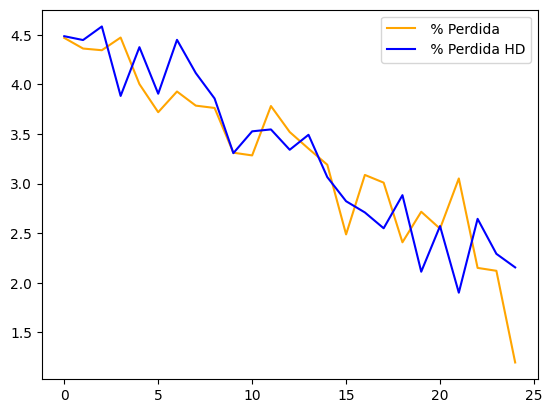

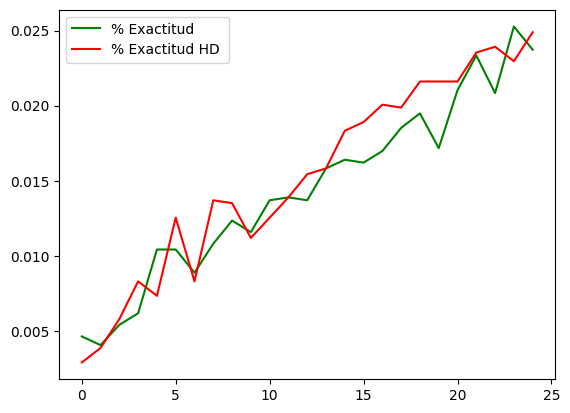

In [22]:
#se genera una tabla comparativa con los resultados de las dos redes
df = pd.DataFrame(results, columns=['Época', '% Perdida', '% Exactitud'])
df_hd = pd.DataFrame(results_hd, columns=['Época', '% Perdida', '% Exactitud'])
df['% Perdida HD'] = df_hd['% Perdida']
df['% Exactitud'] = df['% Exactitud'] * 100
df_hd['% Exactitud'] = df_hd['% Exactitud'] * 100
df['% Exactitud HD'] = df_hd['% Exactitud']
print(df)

#se generan graficas comparativas con los resultados de las dos redes
results = np.array(results)
results_hd = np.array(results_hd)
plt.plot(results[:, 1], label=' % Perdida', color='orange')
plt.plot(results_hd[:, 1], label=' % Perdida HD', color='blue')
plt.legend()
plt.show()

results = np.array(results)
results_hd = np.array(results_hd)
plt.plot(results[:, 2], label='% Exactitud ', color= 'green')
plt.plot(results_hd[:, 2], label='% Exactitud HD ', color= 'red')
plt.legend()
plt.show()



#### Proposicion de mejoras

1. Buscar un método de optimizar estos algoritmos para disminuir el consumo de recursos y minimizar la duracion de la ejecución
2. Se puede aumentar el numero de epocas para asi poder permitir al perceptron desarrollar mejor sus habilidades 

#### Cambios aplicados para la mejora del flujo 

1. Se disminuyó el tamaño de la muesta a un numero mucho menor de clases para clasificar lo que alivió fuertemente las necesidades de procesamineto sin embargo si se comprobó que el algoritmo es capaz de clasificar la colección de imagenes completa. 
2. Se disminuyo la resolucion de las imagenes que compuso un claro avance para el aumento de la velocidad de procesamiento aunque afectando la efectividad de los analisis 
3. Se aplicaron corridas con diferente cantidades de épocas de procesamineto sin embargo quedó demostrado que entre más épocas se aplique aumenta la fiabilidad del modelo.

Todas esta endidas fueron parte de las experimentaciones realizadas.

## Conclusiones


1. La configuracion de los múltiples paramentros de analisis es crucial para el correcto funcionamiento del mecanismo del perceptrón.
2. La capcidad del preceptrón de analizar las imagenes no presenta relación a la definición con la que cuente la imagen que se esta analizando  
3. Entre mayor sea la cantidad de epocas, mejores resultados logra concibir el mecanismo ya que él mismo se auto corrrige y aumenta la presición 
4. Estos mecanimos son altamente pesados anivel de procesamineto y es muy importante contar con equipos de altas prestaciones para realizarlos.

## Referencias
[1] Krajewski, J. (2020). PyTorch layer dimensions: what size and why?. Recuperado de https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

[2] Recommended approach for saving a model. <https://pytorch.org/docs/stable/notes/serialization.html>

[3] Krizhevsky, A., Nair, G, & Hinton, G. The CIFAR-10 dataset (n.d.).  Recuperado de https://www.cs.toronto.edu/~kriz/cifar.html

[4] Tam, Adrian (2023). Building a Convolutional Neural Network in PyTorch. Recuperado de https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/